# Assignment 2
#### Adam Judge - 16343971

## Task 1 - Data Collection

In [32]:
import numpy as np
import urllib.request
import bs4
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import pandas as pd 
import random
pd.set_option("display.max_rows", None)
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
# Small function to obtain html parser
def getParser(url):
    # Request url page
    response = urllib.request.urlopen(url)
    if response.code != 200:
        print("Bad response!")
    # Decode HTML
    html = response.read().decode()    
    # Setup parser of html
    parser = bs4.BeautifulSoup(html, "html.parser")
    return parser

### A list of URLs will be generated through the extraction of the number of pages per month
From viewing the HTML, we can note that the h4 field contains the phase "Page 1 of X", which can be leveraged to obtain all data URLs.

In [3]:
# Get all URLS with data
# All urls start with this
urlBase="http://mlg.ucd.ie/modules/COMP41680/assignment2/month-"
months=["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
urls=[]
# Iterate through months
for m in months:
    # First URL of data per month
    url=urlBase + m + "-001.html"
    parser = getParser(url)
    # h4 field countains "Page 1 of X", extract X to obtain all urls with data
    for match in parser.find_all("h4"):
        text = match.get_text().split()
        # This will be the total number of pages to parse
        pagenum=int(text[-1])
    for num in range(1,pagenum+1):
        # Fit number into URL format
        if num<10:
            urls.append(urlBase+m+f"-00{num}.html")
        elif num<100:
            urls.append(urlBase+m+f"-0{num}.html")
        else:
            urls.append(urlBase+m+f"-{num}.html")

### Categories
##### The chosen categories for this assignment are Music, Sport, and US News. 
The titles, categories, and snippets will now be compiled into relevant lists

The h5 field contains the titles of the article snippets. These must be collected as required. The category of this title is then extracted along with the short text snippet for the story. The titles are combined with the snippets into one string.

This data is then stored in a list of lists.

In [4]:
iter=0
# Categories of interest to the author
cats=["Music", "Sport", "US-News"]
# data[col][row]
# Arrays for data
dataMusic=[]
dataUSNews=[]
dataSport=[]
# snippet=""
for u in urls:
    # Get HTML parser of each URL
    parser = getParser(u)
    titles=[]
    iter=0
    articleNum=0
    # Extract all titles on each URL
    for match in parser.find_all("h5"):
        # Strip number and period from start of titles
        titles.append(match.get_text().lstrip('0123456789. '))
    # p field contains category, times, snippets
    for match in parser.find_all("p"):
        text = match.get_text()
        currCat=text.split()[-1]
        # If category of interest and actually a category
        # Avoids snippets ending in category name
        if text.split()[0] == "Category:":
            articleNum+=1
        if currCat in cats and len(text.split())==2:
            category=currCat
            iter=1
            continue
        if iter == 0:
            # Times not needed
            continue
        if iter == 1:
            # Add data and category to binary data sets
            if category == "Music":
                dataMusic.append([titles[articleNum-1].strip("\xa0") + " " + text, category])
            if category == "US-News":
                dataUSNews.append([titles[articleNum-1].strip("\xa0") + " " +text, category])
            if category == "Sport":
                dataSport.append([titles[articleNum-1].strip("\xa0") + " " +text, category])
            iter=0

### Data Storage
The lists of lists of data are now converted to Dataframes and written to files.

In [5]:
cols=["Title + Snippet", "Category"]
# Dataframes with binary combinations of categories
dfM = pd.DataFrame(dataMusic, columns=cols)
dfU = pd.DataFrame(dataUSNews, columns=cols)
dfS = pd.DataFrame(dataSport, columns=cols)

dfM.to_json("Music_data.json", orient="records")
dfU.to_json("USNews_data.json", orient="records")
dfS.to_json("Sport_data.json", orient="records")

### Reading Data

In [6]:
dfM=pd.read_json("Music_data.json", orient="records")
dfU=pd.read_json("USNews_data.json", orient="records")
dfS=pd.read_json("Sport_data.json", orient="records")


# Make dataframes of multiclass and binary pairs
dfAll=pd.concat([dfM, dfU, dfS], ignore_index=True)
dfMS=pd.concat([dfM, dfS], ignore_index=True)
dfMU=pd.concat([dfM, dfU], ignore_index=True)
dfSU=pd.concat([dfS, dfU], ignore_index=True)

# Shuffle data to scramble data frames
dfAll = dfAll.sample(frac=1).reset_index(drop=True)
dfMS = dfMS.sample(frac=1).reset_index(drop=True)
dfMU = dfMU.sample(frac=1).reset_index(drop=True)
dfSU = dfSU.sample(frac=1).reset_index(drop=True)

# Print dataframe for music
dfAll

,Title + Snippet,Category
0,Trump's lawsuits are diversionary tactic with ...,US-News
1,"FKA twigs sues Shia LaBeouf for physical, ment...",Music
2,US Navy to adopt 'more assertive posture' agai...,US-News
3,'It all crumbled': pop stars on mental health ...,Music
4,Genesis P-Orridge: troubling catalyst who loat...,Music
5,Unexpected timeout offers global sport chance ...,Sport
6,Trump gives up on virus fight to focus on econ...,US-News
7,US supreme court tackles politics’ most tantal...,US-News
8,"Drill, hardcore punk and pop about snails: new...",Music
9,Conspiracy-theorist lawyer Sidney Powell spott...,US-News


## Task 2
### Pre Processing Required
The dataframes have been shuffled to account for any biases which may effect the training/test data splits further on.

The snippets of articles often contain a large amount of irrelevant information, such as words containing little to no information gain such as "this", or "the". These may be removed through the use of CountVectorizer's default english stop_words.

The snippets of text will be converted to numeric representations through the counting and weighting of occurences of words. It is hoped that key words such as "golf" or "football" will allow for a sport document to be differentiated to a US-News document, which likely contains many mentions of key words such as "Trump" or "Election" due to the election year last year.

This representation method is known as Bag-of-Words representation.

In [7]:
# Extracting fields to make code more readable
dataAllSnips=dfAll[cols[0]].tolist()
dataAllCats =dfAll[cols[1]].tolist()

dataMSSnips=dfMS[cols[0]].tolist()
dataMSCats =dfMS[cols[1]].tolist()

dataMUSnips=dfMU[cols[0]].tolist()
dataMUCats =dfMU[cols[1]].tolist()

dataSUSnips=dfSU[cols[0]].tolist()
dataSUCats =dfSU[cols[1]].tolist()

#### The dataset containing Music and US-News will be used in the following sections

In [8]:
# Create vector
v = CountVectorizer()
# Parse terms into term frequencies
x=v.fit_transform(dataMSSnips)
terms=v.get_feature_names()
print(len(terms))

16640


Without using stop words this list of strings contains 16640 terms.
Using the english stop words:

In [9]:
16640# Remove stop words
vStop = CountVectorizer(stop_words="english")
x=vStop.fit_transform(dataMSSnips)
terms=vStop.get_feature_names()
print(len(terms))

16370


There are now 16370 terms, only a mild improvement. Removing sparsely used terms, i.e those used fewer than 5 times reduces the number dramatically

In [10]:
# Remove stop words and ignore occurences less than 5
vStop = CountVectorizer(stop_words="english", min_df=5)
x=vStop.fit_transform(dataMSSnips)
terms=vStop.get_feature_names()
print(len(terms))

2939


There are now 2939 terms which is a significant decrease in terms.
Generating TF-IDF weighted terms using TfidfVectorizer will give increased weighting to more frequent terms

In [11]:
# Weight terms
vStop = TfidfVectorizer(stop_words="english", min_df=5)
x=vStop.fit_transform(dataMSSnips)
terms=vStop.get_feature_names()
print(len(terms))

2939


It was decided to not utilise N-grams i.e sequence information will not be preserved. This is chosen so that the number of terms created is not too large. The chosen categories are likely to be seperated with a high degree of accuracy due to how different the categories are in practice. If US-News, UK-News, and Politics were chosen, then N-Gram methods may be more beneficial and practical.

The vectorizer chosen will remove single length tokens, as well as convert all tokens to lower case.

### Pipelines
Pipelines will allow for elegeant utilisation of cross validation, which will allow for accurate accuracy results with our model. A kNN classifier is used for the classification in this task.

The difference in accuracy is initially examed where the number of nearest neighbours is 3. This will be a constant. The optimal min_df number is found for the three pairs -  Music and Sport, Music and US-News, and Music and Sport. 

Ten fold cross validation was considered while performing parameter exploration, however performing this iteratively with model tuning is not practical with large datasets, such as this application.

### Data Splitting
The dataset is first split into training and testing data with an 80/20 split. The data has been preshuffled to ensure that the dataset is even. Splitting at the beginning helps to ensure that the classifiers never see any test data whilst training.

In [12]:
MS_train_docs, MS_test_docs, MS_train_target, MS_test_target = train_test_split(dataMSSnips, dataMSCats, test_size=0.2)
MU_train_docs, MU_test_docs, MU_train_target, MU_test_target = train_test_split(dataMUSnips, dataMUCats, test_size=0.2)
SU_train_docs, SU_test_docs, SU_train_target, SU_test_target = train_test_split(dataSUSnips, dataSUCats, test_size=0.2)

The assumption is made that parameters suitable for one of the binary classifiers will be suitable for the remaining two classifiers, as the parameters will likely be mostly the same due to the binary classification tasks being quite similar. The Music and Sport data will be used for this section.

In [39]:
# Setup pipeline
maxMin_df=15
#Accuracy storage for each df number
accBinary=[]
for i in range(1,maxMin_df+1):
    # Create pipeline with stop words removed, using TFI-DF transform and kNN=3, vary min_df
    p = Pipeline([
        ('vec', CountVectorizer(stop_words="english", min_df=i)),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors=3))])

    # Train model on training documents and targets
    p.fit(MS_train_docs, MS_train_target)    
    # Predict categories given test documents
    MS_pred=p.predict(MS_test_docs)
    # Evaluate the accuracy of the classifier
    accBinary.append(accuracy_score(MS_test_target, MS_pred))

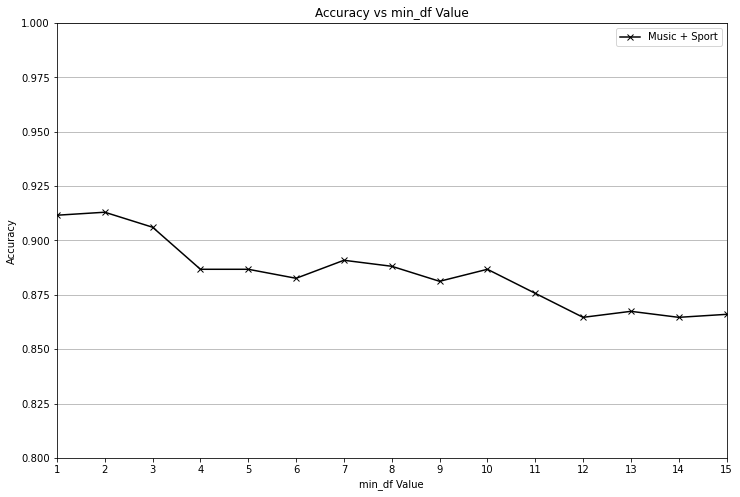

In [48]:
plt.figure(figsize=(12,8));
xAx=range(1,maxMin_df+1)
# Scatter plot of data
plt.plot(xAx, accBinary, marker="x", color="k", label="Music + Sport");
plt.legend()
plt.xlabel("min_df Value")
plt.ylabel("Accuracy")
plt.ylim([.8, 1])
plt.xlim([1, 15])
plt.xticks(xAx)
plt.grid(axis="y")
plt.title("Accuracy vs min_df Value");

#### We can see that the accuracy alone is highest for low values of min_df, however setting a value of 3 results in a very large reduction in size and will be chosen. The accuracy declines as the min_df value increases, due to information loss associated with removing data. This is a tradeoff between reducing the size of the dataset and the accuracy

The effect of not using stop words is briefly explored also, using min_df=3 and k=3

<span style="color:red">Note can be taken that cross validation is used here, as we are evaluating one variance</span>.

In [157]:

# Generate pipeline without removing stop words
p1 = Pipeline([
    ('vec', CountVectorizer(min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))])

# Generate pipeline with removing stop words
p2 = Pipeline([
    ('vec', CountVectorizer(stop_words="english", min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))])

# Accuracies from 10 fold cross validation on Music + Sport without removing stop words
accMS_nosw = cross_val_score(p1, dataMSSnips, dataMSCats, cv=5, scoring="accuracy")

# Accuracies from 10 fold cross validation on Music + Sport with removing stop words
accMS_sw = cross_val_score(p2, dataMSSnips, dataMSCats, cv=5, scoring="accuracy")
accsw=accMS_nosw.mean()
accnsw=accMS_nosw.mean()
# Calculate differences
accdif=accMS_nosw.mean()-accMS_nosw.mean()

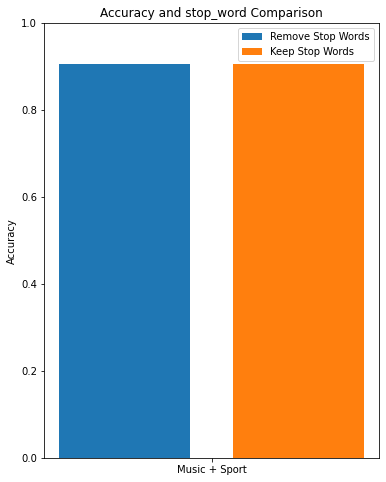

In [158]:
# Plot bar charts
plt.figure(figsize=(6,8))
w=0.3
xlabels=["Music + Sport"]
x=np.arange(len(xlabels))
plt.bar(x-w/3, accsw, w/2, label="Remove Stop Words")
plt.bar(x+w/3, accnsw, w/2, label="Keep Stop Words")
plt.xticks(x,xlabels);
plt.ylabel("Accuracy")
plt.title("Accuracy and stop_word Comparison")
plt.ylim([0,1])
plt.legend();

There is practically no discernable difference in accuracy and the use of stop words on these data sets. The default English stop words will be removed in any case to reduce the size.

The effect of the number of nearest neighbours will now be explored with min_df=3. An estimate for the expected value of k is often near the square root of the total number of elements.

In [61]:
# Setup pipeline
kMax=200
accBinary=[]
# Iterate every 5 neighbours up to limit
for i in range(5,kMax+1,5):
    # Generate pipeline with min_df=4, TFI_DF transform, kNN=i
    p = Pipeline([
        ('vec', CountVectorizer(stop_words="english", min_df=3)),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors=i))])

    # Train model on training documents and targets
    p.fit(MS_train_docs, MS_train_target)    
    # Predict categories given test documents
    MS_pred=p.predict(MS_test_docs)
    # Evaluate the accuracy of the classifier
    accBinary.append(accuracy_score(MS_test_target, MS_pred))

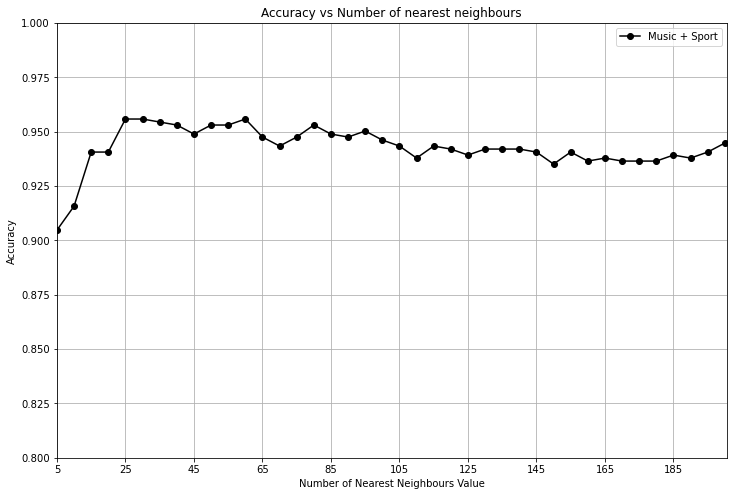

In [65]:
# Plot accuracies for all binary classifiers with varying k
plt.figure(figsize=(12,8));
xAx=range(5,kMax+1,5)
plt.plot(xAx, accBinary, marker="o", color="k", label="Music + Sport");
plt.legend()
plt.xlabel("Number of Nearest Neighbours Value")
plt.ylabel("Accuracy")
plt.ylim([.8, 1])
plt.xlim([5, kMax+.5])
plt.xticks(range(5,kMax+1, 20))
plt.grid()
plt.title("Accuracy vs Number of nearest neighbours");

In [71]:
X=(accBinary.index(max(accBinary))+1)*5
print(f"The highest accuracy is obtained from the number of nearest neighbours is {X} for Music and Sport")
print(f"These result inaccuracies of {round(max(accBinary)*100,2)}%")

The highest accuracy is obtained from the number of nearest neighbours is 25 for Music and Sport
These result inaccuracies of 95.58%


The number of nearest neighbours chosen for this binary classification task is 30, as the accuracy is quite stable around this value. As the number of nearest neighbours continues to grow, it appears that the accuracy decreases as it exceeds 100.

### Training Models
The parameters for kNN have been determined and will not be applied to the three binary classification tasks. The classifier will make use of kNN with k=30, min_df=3, vectorisation using TF-IDF, with the default English stop words removed.

The confusion matrices of these specific clasifiers will help in determining if the model is producing good outputs, i.e that it is not assigning to a majority class for example and ignoring one class entirely. This coupled with the accuracy score will provide a good basis for the evaluation of our classifiers. Two functions are created for training and testing/evaluating. This will reduce duplicate code.

In [153]:
# Function to train and evaluate on the given training data
def trainAndEval(k, train_doc, train_target, test_docs, test_target, lab):
    m=KNeighborsClassifier(n_neighbors=k)
    # Get vector with stop words removed and min_df=3
    v= TfidfVectorizer(stop_words="english", min_df=4)
    # Transform vector to fit training doc
    X= v.fit_transform(train_doc)
    # Preprocess test data the same way
    Xtest = v.transform(test_docs)
    # Train the model with the training data and targets
    m.fit(X, train_target)
    # Predict test data
    predictions=m.predict(Xtest)
    # Get probability of prediction
    predictions_prob=m.predict_proba(Xtest)[:,1]
    # Get accuracy
    acc=accuracy_score(test_target, predictions)*100
    # Get AUC
    AUC=roc_auc_score(test_target, predictions_prob)
    # Get confusion matrix
    cm = confusion_matrix(test_target, predictions, labels=lab)
    print(f"{lab[0]} - {lab[1]}:")
    print(f"Accuracy: {round(acc,3)}%")
    print(f"AUC: {round(AUC,3)}")
    print(f"Confusion Matrix:\n{lab[0]} {lab[1]}")
    print(cm)
    print("\n")
    return m, v, acc

In [154]:
_,_,accMS=trainAndEval(30, MS_train_docs, MS_train_target, MS_test_docs, MS_test_target, ["Music", "Sport"])
_,_,accMU=trainAndEval(30, MU_train_docs, MU_train_target, MU_test_docs, MU_test_target, ["Music", "US-News"])
_,_,accSU=trainAndEval(30, SU_train_docs, SU_train_target, SU_test_docs, SU_test_target, ["Sport", "US-News"]);


Music - Sport:
Accuracy: 94.613%
AUC: 0.986
Confusion Matrix:
Music Sport
[[342  14]
 [ 25 343]]


Music - US-News:
Accuracy: 95.574%
AUC: 0.988
Confusion Matrix:
Music US-News
[[310  20]
 [ 12 381]]


Sport - US-News:
Accuracy: 94.223%
AUC: 0.987
Confusion Matrix:
Sport US-News
[[340  26]
 [ 16 345]]




There are roughly as many type 1 errors as type 2 and predictions are not being made to any majority class as there is clearly no majority class present here. There is a low number of false negatives and false positives, with amounts reflecting the accuracy of our models

The achieved accuracy levels of between 94 and 96% show that these models are very good at discerning snippets of text pertaining to a specific category of text. The additional pre-processing and exploration has yielded an accuracy gain of at least 4%.

Finally the AUC for all three binary classifiers is very high, around 0.99 for all. A value of 0.9 or more indicates a very strong classifier.

## Task 3
The steps undertaken for comparing all three categories is broadly similar.
kNN will be explored as well as Stochastic Gradient Descent as our methods of multiclass classification.

### Data Splitting
Again data is split into training and test data at an 80/20 split early so as to ensure no test data is seen during training.

In [160]:
# Split data into 80 20 training test
train_docs, test_docs, train_target, test_target = train_test_split(dataAllSnips, dataAllCats, test_size=0.2)

### kNN
The same min_df of 3 will be used, with the default English stop_words being removed from the document.
Exploring the accuracy through varying k:

Again cross validation is not used at this exploratory stage for the aforementioned reasonsFinally the AUC for all three binary classifiers is very high, around 0.99 for all. A value of 0.9 or more indicates a very strong classifier.


In [168]:
# Setup pipeline
maxk=200
acc=[]
for i in range(5,maxk+1,5):
    # Pipeline with min_df=4, stop words removed, and kNN classifier with k=i
    p = Pipeline([
        ('vec', CountVectorizer(stop_words="english", min_df=3)),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors=i))])
    # Train model on training documents and targets
    p.fit(train_docs, train_target)    
    # Predict categories given test documents
    pred=p.predict(test_docs)
    # Evaluate the accuracy of the classifier
    acc.append(accuracy_score(test_target, pred))

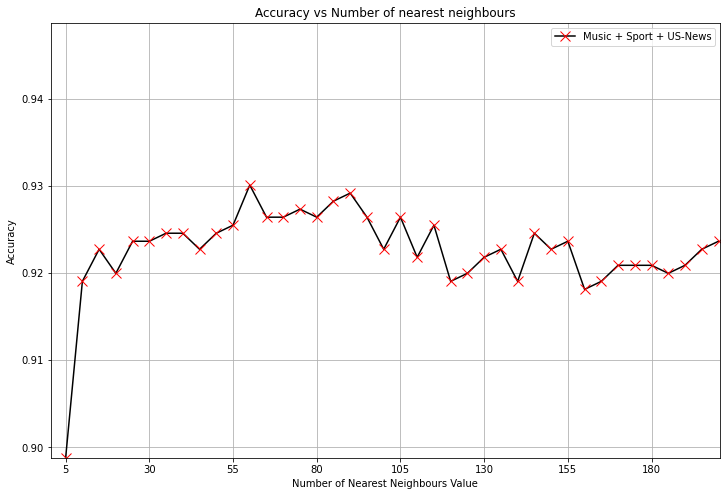

In [176]:
# Plot accuracies of multi class over range of k
plt.figure(figsize=(12,8));
xAx=range(5,maxk+1,5)
plt.plot(xAx, acc,'k', marker="x", markeredgecolor="r",ms=10, label="Music + Sport + US-News");
plt.legend()
plt.xlabel("Number of Nearest Neighbours Value")
plt.ylabel("Accuracy")
plt.ylim([min(acc), max(acc)*1.02])
plt.xlim([0.5, kMax+.5])
plt.xticks(range(5,maxk+1,25))
plt.grid()
plt.title("Accuracy vs Number of nearest neighbours");

In [177]:
X=(acc.index(max(acc))+1)*5
print(f"The highest accuracy is obtained from the number of nearest neighbours is {X} for Music, Sport, and US-News")
print(f"This result in accuracies of {round(max(acc)*100,2)}%")

The highest accuracy is obtained from the number of nearest neighbours is 60 for Music, Sport, and US-News
This result in accuracies of 93.01%


The highest accuracy is observed where k is around 60. This results in an accuracy of around 93%, lower than binary classifications as would be expected due to the increased complexity of the problem, however this accuracy seems quite good due to the complexities of lexical differentiation.

### Stochastic Gradient Descent
As with kNN, a pipeline will be created with the same parameters, except the SGDClassifier will be used instead for classification. SGD is typically best for large datasets The alpha and number of iterations parameters will be briefly explored. A baseline accuracy is obtained with no parameters using cross validation.

In [179]:
# Stochastic gradient descent pipeline with stop words removed, min_df=4, TFI-DF transform
psgd = Pipeline([
    ('vec', CountVectorizer(stop_words="english", min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())])
# Cross validation with ten folds
acc_sgd = cross_val_score(psgd, dataAllSnips, dataAllCats, cv=5, scoring="accuracy")
accsgd=acc_sgd.mean()
print(f"The accuracy achieved with SGD is {round(accsgd,2)*100}%")

The accuracy achieved with SGD is 95.0%


The accuracy with SGD appears to be higher by approximately 2% over consecutive runs. 

Exploring a range of alpha and n_iter parameter values


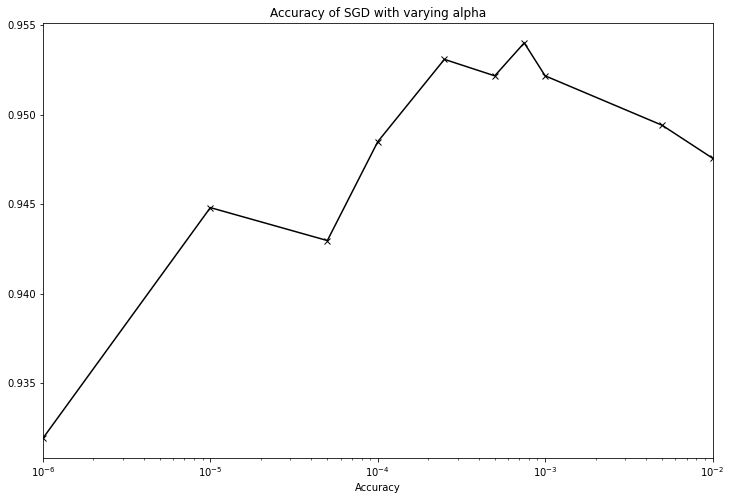

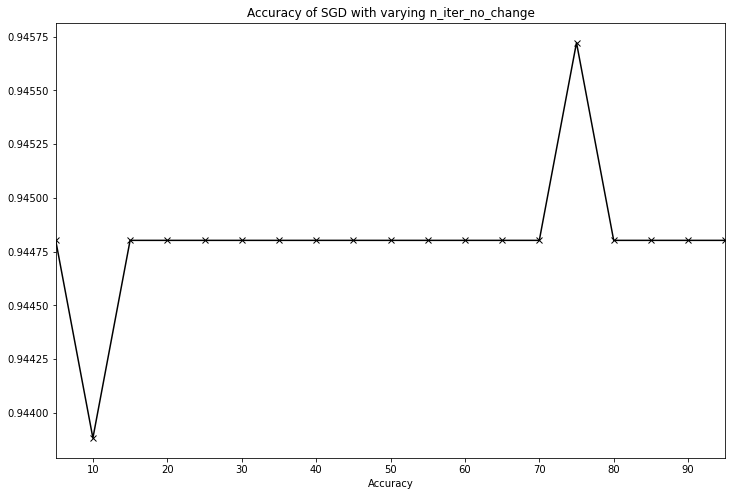

In [248]:
alphamin=0.00001
alphamax=0.0002
alp=[0.000001, 0.00001, 0.00005, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.01]
accAlp=[]
accNit=[]
# Iterate every 5 neighbours up to limit
for i in alp:
    # Generate pipeline with min_df=4, TFI_DF transform, kNN=i
    p = Pipeline([
        ('vec', CountVectorizer(stop_words="english", min_df=3)),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(alpha=i))])

    # Train model on training documents and targets
    p.fit(train_docs, train_target)    
    # Predict categories given test documents
    pred=p.predict(test_docs)
    # Evaluate the accuracy of the classifier
    accAlp.append(accuracy_score(test_target, pred))
plt.figure(figsize=(12,8));
plt.plot(alp, accAlp, 'k',  marker="x")
plt.title("Accuracy of SGD with varying alpha")
plt.xlabel("Accuracy")
plt.gca().set_xscale("log")
plt.xlim([min(alp), max(alp)]);


n_its=range(5,100,5)
for i in n_its:
    # Generate pipeline with min_df=4, TFI_DF transform, kNN=i
    p = Pipeline([
        ('vec', CountVectorizer(stop_words="english", min_df=3)),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(n_iter_no_change=i))])

    # Train model on training documents and targets
    p.fit(train_docs, train_target)    
    # Predict categories given test documents
    pred=p.predict(test_docs)
    # Evaluate the accuracy of the classifier
    accNit.append(accuracy_score(test_target, pred))
plt.figure(figsize=(12,8));
plt.plot(n_its, accNit, 'k',  marker="x")
plt.title("Accuracy of SGD with varying n_iter_no_change")
plt.xlabel("Accuracy")
plt.xlim([min(n_its), max(n_its)]);

The accuracy of SGD improves marginally where alpha is 0.00075, giving a quarter percent gain. Varying the number of iterations with no change resulted in no discernable change in accuracy.
## Model Decision
Comparing the confusion matrices will allow for us to determine if the SGD is indeed better than our kNN model. AUC is not used as confusion matrices are better for multiclass evaluation

In [252]:
#SGD classifier
m_SGD=SGDClassifier(alpha=0.00075)
#kNN classifier
m_kNN=KNeighborsClassifier(n_neighbors=30)

# Get vector with stop words removed and min_df=3
vall= TfidfVectorizer(stop_words="english", min_df=3)
# Transform vector to fit training doc
Xall= vall.fit_transform(train_docs)
# Preprocess test data the same way
Xall_test = vall.transform(test_docs)
# Train the model with the training data and targets
m_SGD.fit(Xall, train_target)
m_kNN.fit(Xall, train_target)
# Predict test data
SGD_predictions=m_SGD.predict(Xall_test)
kNN_predictions=m_kNN.predict(Xall_test)

# Accuracy Score
SGD_acc=accuracy_score(test_target, SGD_predictions)
kNN_acc=accuracy_score(test_target, kNN_predictions)

# Get confusion matrix
cm_SGD = confusion_matrix(test_target, SGD_predictions, labels=["Music", "Sport", "US-News"])
cm_kNN = confusion_matrix(test_target, kNN_predictions, labels=["Music", "Sport", "US-News"])
print("SGD Confusion Matrix:")
print(cm_SGD)
print(f"SGD Accuracy: {round(SGD_acc,2)*100}%")
print("kNN Confusion Matrix:")
print(cm_kNN)
print(f"kNN Accuracy: {round(kNN_acc,2)*100}%")


SGD Confusion Matrix:
[[347   5  12]
 [ 10 327   7]
 [ 12   6 361]]
SGD Accuracy: 95.0%
kNN Confusion Matrix:
[[330  14  20]
 [ 16 319   9]
 [ 15   9 355]]
kNN Accuracy: 92.0%


## Conclusion
Both models possess good quality confusion matrices with no majority classes selected with low levels of false positives/negatives. From this, the SGD method of multiclass classification is our preferred method, with an accuracy of 95%.

From the above confusion matrix, the classifier is better at categorizing US-News from Sport and Music as can be seen by the higher TP rate in the lower right hand corner of the confusion matrix relative to the other two TP values. This was expected as this category is more distinct compared to Music and Sport. The abundance of mentions of Trump and Biden in the dataset no doubt made it easier for the classifier.

Sport and music are broadly similar, with Music being the most difficult to categorise out of the three categories.

The generated model is able to categorize with an accuracy of approximately 94-95% from small snippets of articles.

All classifiers created in this assignment have performed very well, achieving close to 95% accuracy across the board.